In [1]:
import pandas as pd
import numpy as np
import os
from sklearn.cluster import AgglomerativeClustering
from igraph import Graph, plot
import matplotlib.pyplot as plt
import skbio
import subprocess
import utils
import manta
from scipy.cluster.hierarchy import dendrogram
import itertools
from matplotlib_venn import venn3, venn3_circles
from matplotlib_venn import venn2, venn2_circles
from collections import Counter
from venn import venn

%load_ext autoreload
%aimport utils
%aimport manta
%autoreload 1

# Read data and preprocess

In [2]:
T = '16S'
TAX_LEVEL = 4
OUTDIR = 'data/16S_family_pu'
SEASON = 'Peak Upwelling'

In [72]:
# Read data
df_raw = pd.read_excel('data/16S_AV_OTU_table_wTaxa.xlsx')
meta = pd.read_excel('data/16S_AV_March2019_Metadata.xlsx')
meta

,Sample_Names,Sample_NamesR,AV_Numbers,Month,Year,Season,Temp_C,Salinity,Chlorophyll_ugL
0,AV12-16S,AV12_Jan_2018,AV180126,January,2018,Winter Storms,12.60,33.4,NaN
1,AV13-16S,AV13_Feb_2018,AV180202,February,2018,Winter Storms,13.80,33.4,NaN
2,AV14-16S,AV14_Feb_2018,AV180209,February,2018,Winter Storms,14.30,33.4,18.916
3,AV18-16S,AV18_Feb_2018,AV180223,February,2018,Winter Storms,12.20,33.5,1.818
4,AV19-16S,AV19_Mar_2018,AV180302,March,2018,March Transition,11.50,33.3,1.113
5,AV22-16S,AV22_Mar_2018,AV180309,March,2018,March Transition,12.72,33.4,7.338
6,AV23-16S,AV23_Mar_2018,AV180316,March,2018,March Transition,13.00,33.4,3.602
7,AV26-16S,AV26_Apr_2018,AV180413,April,2018,Peak Upwelling,10.60,33.7,0.652
8,AV29-16S,AV29_Apr_2018,AV180420,April,2018,Peak Upwelling,11.30,33.3,8.615
9,AV32-16S,AV32_Apr_2018,AV180427,April,2018,Peak Upwelling,12.80,33.7,1.394


In [73]:
df_raw = df_raw.set_index('OTU').loc[otus]

In [74]:
# Split taxonomy
df_raw['taxonomy'] = df_raw['taxonomy'].str.split('; ')
# Taxonomy depth distribution
tax_depth = df_raw['taxonomy'].apply(len)
tax_depth.value_counts()

6    183
5     38
4      8
3      2
Name: taxonomy, dtype: int64

In [45]:
len(df_raw)

32

In [75]:
# Filter out OTUs with coarser taxonomy than the desired level and group them at that level
df_raw = df_raw[tax_depth >= TAX_LEVEL]
df_raw['taxonomy'] = df_raw['taxonomy'].apply(lambda x: '; '.join(x[:TAX_LEVEL]))
df = df_raw.groupby('taxonomy').aggregate(np.sum)
df

,AV78-16S,AV18-16S,AV75-16S,AV66-16S,AV29-16S,AV41-16S,AV56-16S,AV47-16S,AV38-16S,AV50-16S,...,AV59-16S,AV12-16S,AV90-16S,AV13-16S,AV14-16S,AV22-16S,AV81-16S,AV69-16S,AV84-16S,AV53-16S
taxonomy,,,,,,,,,,,,,,,,,,,,,
Archaea; __Euryarchaeota; __Thermoplasmata; __Thermoplasmatales,9,217,0,17,1,3,57,171,7.0,12,...,18,51,128,0,3,13,5,0,29,14
Archaea; __Thaumarchaeota; __Marine_Group_I; __o,210,4861,13,85,635,1,19,32,12.0,22,...,35,3470,3985,330,1,13,37,7,1,49
Bacteria; __Actinobacteria; __Acidimicrobiia; __Acidimicrobiales,1211,9982,73,3068,946,0,1487,92,1.0,788,...,1433,2333,1394,1721,220,260,164,53,148,1475
Bacteria; __Bacteroidetes; __Flavobacteriia; __Flavobacteriales,26626,104597,30823,20384,81895,26692,19859,21023,55772.0,19345,...,15565,13564,16374,33680,1680,27562,45184,25057,3517,17715
Bacteria; __Bacteroidetes; __Sphingobacteriia; __Sphingobacteriales,320,699,483,1605,412,2073,658,2422,581.0,1693,...,1301,175,32,284,5,23,292,332,3,1662
Bacteria; __Cyanobacteria; __Cyanobacteria; __SubsectionI,4377,11946,2247,3670,2090,53,1997,117,30.0,3283,...,2904,2634,1559,1495,318,369,1085,670,813,5364
Bacteria; __Deferribacteres; __Deferribacteres; __Deferribacterales,36,447,0,33,35,0,24,9,0.0,21,...,23,253,141,19,2,6,0,0,2,9
Bacteria; __Planctomycetes; __Planctomycetacia; __Planctomycetales,912,6120,455,603,1654,154,358,249,48.0,184,...,806,2810,1966,486,12,372,197,592,8,1788
Bacteria; __Proteobacteria; __Alphaproteobacteria; __Caulobacterales,80,713,23,168,393,163,182,360,62.0,184,...,148,143,19,335,22,535,56,79,6,73


In [78]:
df.index

Index(['Archaea; __Euryarchaeota; __Thermoplasmata; __Thermoplasmatales',
       'Archaea; __Thaumarchaeota; __Marine_Group_I; __o',
       'Bacteria; __Actinobacteria; __Acidimicrobiia; __Acidimicrobiales',
       'Bacteria; __Bacteroidetes; __Flavobacteriia; __Flavobacteriales',
       'Bacteria; __Bacteroidetes; __Sphingobacteriia; __Sphingobacteriales',
       'Bacteria; __Cyanobacteria; __Cyanobacteria; __SubsectionI',
       'Bacteria; __Deferribacteres; __Deferribacteres; __Deferribacterales',
       'Bacteria; __Planctomycetes; __Planctomycetacia; __Planctomycetales',
       'Bacteria; __Proteobacteria; __Alphaproteobacteria; __Caulobacterales',
       'Bacteria; __Proteobacteria; __Alphaproteobacteria; __OCS116_clade',
       'Bacteria; __Proteobacteria; __Alphaproteobacteria; __Rhodobacterales',
       'Bacteria; __Proteobacteria; __Alphaproteobacteria; __Rickettsiales',
       'Bacteria; __Proteobacteria; __Alphaproteobacteria; __SAR11_clade',
       'Bacteria; __Proteobacte

In [63]:
df_relative = df_raw / df_raw.sum()

In [66]:
(df_relative >= .001).any(axis=1).sum()

231

In [69]:
df_raw = df_raw[(df_relative >= .001).any(axis=1)]

In [70]:
otus = df_raw.index

In [79]:
len(otus)

231

In [35]:
df_relative

,AV26-16S,AV29-16S,AV32-16S,AV35-16S,AV38-16S,AV41-16S,AV44-16S
OTU,,,,,,,
denovo100000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.00000
denovo100006,0.000013,0.0,0.0,0.000000,0.0,0.000000,0.00000
denovo100014,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.00003
denovo100019,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.00000
denovo100021,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.00000
...,...,...,...,...,...,...,...
denovo99979,0.000027,0.0,0.0,0.000065,0.0,0.000026,0.00004
denovo99988,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.00000
denovo99993,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.00000


In [62]:
samples = meta['Sample_Names'][meta['Season'] == SEASON]
df_raw = df_raw[samples]

In [61]:
df_raw = df_raw.groupby('OTU').aggregate(np.sum)

In [ ]:
# Effective number of species
np.exp(skbio.diversity.alpha_diversity('shannon', df.transpose())).mean()

# Filter vertices

In [7]:
samples = meta['Sample_Names'][meta['Season'] == SEASON]
df = df[samples]

In [7]:
df_relative = df / df.sum()
df = df[(df_relative > .01).any(axis=1)]

In [9]:
len(df)

22

In [16]:
df.to_csv('16s_pu_1percent_4samples.csv')

# Build graph

In [60]:
df_cor, df_pval = utils.run_sparcc(df, OUTDIR, force=True)

(array([ 37., 114., 173., 253., 260., 237., 219., 122.,  91.,  34.]),
 array([-0.8867 , -0.70352, -0.52034, -0.33716, -0.15398,  0.0292 ,
         0.21238,  0.39556,  0.57874,  0.76192,  0.9451 ]),
 <a list of 10 Patch objects>)

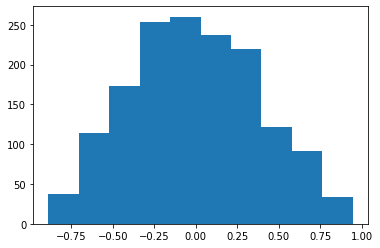

In [61]:
flatten_cor = utils.flatten_square_df(df_cor, k=1)
plt.hist(flatten_cor)

In [62]:
g = utils.build_graph(df_cor, df_pval)
utils.graph_stats(g)

# edges: 72
# positive edges: 46
# negative edges: 26
max degree: 9
min degree: 1
median degree: 3.0
transitivity: 0.487012987012987


In [63]:
len(g.vs)

40

# Run manta

In [66]:
g.write_gml(os.path.join(OUTDIR, 'graph.gml'))

In [78]:
for i in range(20):
    try:
        subprocess.run(['manta',
                        '-i', os.path.join(OUTDIR, 'graph.gml'),
                        '-o', os.path.join(OUTDIR, 'graph_manta'),
                        '-min', '2',
                        '-max', '2',
                        '-f', 'gml',
                        '-b',
                        '-iter', '40'
                       ],
                       check=True)
    except:
        print(i)
        continue
    break
g_manta = Graph.Read_GML(os.path.join(OUTDIR, 'graph_manta.gml'))

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


In [10]:
g_manta = Graph.Read_GML(os.path.join(OUTDIR, 'graph_manta.gml'))

In [11]:
utils.graph_stats(g_manta)

# edges: 72
# positive edges: 46
# negative edges: 26
max degree: 9
min degree: 1
median degree: 3.0
transitivity: 0.487012987012987


In [12]:
Counter(g_manta.vs['assignment'])

KeyError: 'Attribute does not exist'

In [13]:
Counter(g_manta.vs['cluster'])

Counter({1.0: 19, 0.0: 21})

In [91]:
# g_manta.vs['up_one_level'] = list(map(lambda x: '; '.join(x.split('; ')[:-1]), g_manta.vs['label']))
# from collections import defaultdict
# up_one_level_to_clusters = defaultdict(set)
# up_one_level_to_ids = defaultdict(list)
# for v in g_manta.vs:
#     up_one_level_to_clusters[v['up_one_level']].add(v['cluster'])
#     up_one_level_to_ids[v['up_one_level']].append(v['id'])
# id_groups = []
# for up_one_level, clusters in up_one_level_to_clusters.items():
#     if len(clusters) == 1:
#         id_group = up_one_level_to_ids[up_one_level]
#         if len(id_group) > 1:
#             id_groups.append(id_group)

In [16]:
g_manta.vs.select(cluster=1.0)['label']

['Archaea; __Euryarchaeota; __Thermoplasmata; __Thermoplasmatales',
 'Bacteria; __Bacteroidetes; __Bacteroidetes_Incertae_Sedis; __Unknown_Order',
 'Bacteria; __Bacteroidetes; __Flavobacteriia; __Flavobacteriales',
 'Bacteria; __Bacteroidetes; __Sphingobacteriia; __Sphingobacteriales',
 'Bacteria; __Cyanobacteria; __Cyanobacteria; __SubsectionII',
 'Bacteria; __Deinococcus_Thermus; __Deinococci; __Deinococcales',
 'Bacteria; __Planctomycetes; __OM190; __o',
 'Bacteria; __Proteobacteria; __Alphaproteobacteria; __Caulobacterales',
 'Bacteria; __Proteobacteria; __Alphaproteobacteria; __OCS116_clade',
 'Bacteria; __Proteobacteria; __Alphaproteobacteria; __Rhodobacterales',
 'Bacteria; __Proteobacteria; __Alphaproteobacteria; __Rickettsiales',
 'Bacteria; __Proteobacteria; __Betaproteobacteria; __Hydrogenophilales',
 'Bacteria; __Proteobacteria; __Betaproteobacteria; __Methylophilales',
 'Bacteria; __Proteobacteria; __Gammaproteobacteria; __Gammaproteobacteria_Incertae_Sedis',
 'Bacteria; _

In [17]:
df_relative = df_relative.loc[g_manta.vs['label']]
df_relative = df_relative / df_relative.sum()

In [18]:
df_relative_mean = df_relative.mean(axis=1)

In [19]:
g_manta.vs['abundance'] = list(map(lambda x: df_relative_mean[x], g_manta.vs['label']))

In [110]:
# sets = {
#     'pu_0': set(g_pu_manta.vs.select(cluster=0.0)['label']),
#     'pu_1': set(g_pu_manta.vs.select(cluster=1.0)['label']),
#     'ur_0': set(g_ur_manta.vs.select(cluster=0.0)['label']),
#     'ur_1': set(g_ur_manta.vs.select(cluster=1.0)['label'])
# }
# fig, ax = plt.subplots(1, figsize=(16,12))
# venn(sets, ax=ax)
# #plt.legend(labels[:-2], ncol=6)

In [20]:
g_manta.es['abs_weight'] = list(map(abs, g_manta.es['weight']))

In [21]:
def assign_color(e):
    if e.source_vertex['cluster'] == e.target_vertex['cluster']:
        return 'green' if e['weight'] >= 0 else 'red'
    else:
        return 'blue' if e['weight'] >= 0 else 'orange'
g_manta.es['color'] = list(map(assign_color, g_manta.es))

In [113]:
# def clean_label(label):
#     return '; '.join(map(lambda x: x.strip('_'), label.split('; ')[1:]))
# g_manta.vs['label'] = list(map(clean_label, g_manta.vs['label']))

In [22]:
g_manta.write_gml(os.path.join(OUTDIR, 'graph_cytoscape.gml'))

In [ ]:
g_pu.es.find(_between=((80,), (7,)))['weight']

In [ ]:
for clique in g_pu.cliques(3):
    all_negative = True
    for v1,v2 in itertools.combinations(clique, 2):
        if g_pu.es.find(_between=((v1,), (v2,)))['weight'] > 0:
            all_negative = False
    if all_negative:
        print(clique)

In [ ]:
g_pu.es.select(weight_lt=0).delete()
g_ur.es.select(weight_lt=0).delete()
g_pu.vs.select(_degree=0).delete()
g_ur.vs.select(_degree=0).delete()

In [ ]:
g_ur.clique_number()

In [ ]:
# p, labels = plot_graph(g_pu)
# p

In [ ]:
# g_pu.vs['label'] = labels

In [ ]:
# p, labels = plot_graph(g_ur)
# p

In [ ]:
# g_ur.vs['label'] = labels

In [ ]:
# hierarchical clustering
adjacency_matrix = np.array(g_pu.get_adjacency(attribute='weight').data)
adjacency_matrix[adjacency_matrix < 0] = 0
# adjacency_matrix = (adjacency_matrix + 1) / 2
adjacency_matrix = 1 - adjacency_matrix
clusteror = AgglomerativeClustering(n_clusters=None, affinity='precomputed', linkage='complete', distance_threshold=.5)
a = clusteror.fit_predict(adjacency_matrix)

In [ ]:
def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_,
                                      counts]).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)
plt.title('Hierarchical Clustering Dendrogram')
# plot the top three levels of the dendrogram
plot_dendrogram(clusteror, truncate_mode='level', p=3)
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.show()

In [ ]:
# for e in g_pu.es.select(weight_ge=.7):
#     print(e.source_vertex['label'], e.target_vertex['label'], e['weight'])

In [ ]:
# plot(g_pu.degree_distribution())

In [ ]:
# for v in g_pu.vs.select(_degree_ge=40):
#     print(v['label'])

In [ ]:
# ccs = g_pu.components()
# ccs = [ccs.subgraph(i) for i, vs in enumerate(ccs) if len(vs) > 1]
# print(f'Number of components: {len(ccs)}')

In [ ]:
# for cc in ccs:
#     print(len(cc.vs))

In [ ]:
clustering = g_pu.community_fastgreedy().as_clustering()
#small = [clustering.subgraph(i) for i, vs in enumerate(clustering) if len(vs) < 10][0]
#ccs[0].vs['label'] = None
#plot(clustering)

In [ ]:
for i in range(len(clustering)):
    module = clustering.subgraph(i)
    for v in module.vs:
        print(v['label'])
    print()

In [ ]:
clustering = g_ur.community_fastgreedy().as_clustering()
for i in range(len(clustering)):
    module = clustering.subgraph(i)
    for v in module.vs:
        print(v['label'])
    print()